# Machine Learning for Forex

This model will use a linear regression to try to identify possible trend patterns on the pair USDJPY.

This is just a test to identify the capabilities of Technical indicators to predict future moves on the market  

In [1]:
import pandas as pd
df = pd.read_csv("USDJPY60.csv")
df.tail()

,Date,Hour,open,high,low,close,volume
66019,2022.12.09,19:00,136.402,136.507,136.331,136.463,3842
66020,2022.12.09,20:00,136.465,136.504,136.331,136.414,2627
66021,2022.12.09,21:00,136.411,136.504,136.373,136.469,2739
66022,2022.12.09,22:00,136.471,136.688,136.438,136.688,2788
66023,2022.12.09,23:00,136.687,136.709,136.503,136.527,2071


In [2]:
# clean the data, remove all the index that are Zero volume
index_zeros = df[df['volume'] == 0].index
df.drop(index_zeros, inplace = True)
df.loc[(df["volume"] == 0)]
df.isna().sum()

Date      0
Hour      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

## Here we are getting the values of technical indicators 

I had an hypothesis that will also try to test on other models, and is the slope of those indicators.
Let me elaborate more, i would like to test the effectivenes of the slope value with indicators and see if there is a possible edge to be explore.

What are we looking is a high number of predictibale moments on any of both trends (buy or sell)

In [3]:
import numpy as np
import pandas_ta as ta

df['ATR'] = df.ta.atr(length = 15)
df['RSI'] = df.ta.rsi(length = 13)
df['AVG'] = df.ta.midprice()
df['MA21'] = df.ta.ema(length=21)
df['MA50'] = df.ta.ema(length=50)
df['MA200'] = df.ta.ema(length=200)

from scipy.stats import linregress
def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope


backrolling_n= 12

df['slopeMA21'] = df['MA21'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeMA50'] = df['MA50'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeMA200'] = df['MA200'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeAVG'] = df['AVG'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeRSI'] = df['RSI'].rolling(window=backrolling_n).apply(get_slope, raw=True)
df['slopeATR'] = df['ATR'].rolling(window=backrolling_n).apply(get_slope, raw=True)

In [4]:
df.tail()

,Date,Hour,open,high,low,close,volume,ATR,RSI,AVG,MA21,MA50,MA200,slopeMA21,slopeMA50,slopeMA200,slopeAVG,slopeRSI,slopeATR
66019,2022.12.09,19:00,136.402,136.507,136.331,136.463,3842,0.359220,53.830258,136.4285,136.298571,136.430701,136.924439,-0.013142,-0.012326,-0.008022,0.027974,1.312972,0.010495
66020,2022.12.09,20:00,136.465,136.504,136.331,136.414,2627,0.346805,52.439779,136.4190,136.309064,136.430047,136.919360,-0.009251,-0.010679,-0.007647,0.029119,1.188449,0.010220
66021,2022.12.09,21:00,136.411,136.504,136.373,136.469,2739,0.332418,53.888148,136.4175,136.323604,136.431574,136.914878,-0.004411,-0.008535,-0.007133,0.033645,1.522177,0.009377
66022,2022.12.09,22:00,136.471,136.688,136.438,136.688,2788,0.326923,59.242277,136.5305,136.356731,136.441630,136.912621,0.001585,-0.005787,-0.006449,0.042308,1.902360,0.007796
66023,2022.12.09,23:00,136.687,136.709,136.503,136.527,2071,0.318862,54.227626,136.5735,136.372210,136.444978,136.908784,0.007579,-0.002913,-0.005713,0.054892,1.928598,0.005387


On this Following area we will use a very basic risk management strategy but these items are to be tested and improved

In [6]:
# Targets are flexible
pip_difference = 350*1e-3 # this is -3 because we using a XXXJPY so the price goes as 132.123 and 500 means 50 pips
RRratio = 2 # this is the risk reward ratio the higher the better

def my_target(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length 
    
    for line in range (0,length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range (1,barsupfront +2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pip_difference) and (-valueOpenHigh <= (pip_difference/RRratio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pip_difference/RRratio)) and (-valueOpenHigh >= pip_difference) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [7]:
df['MyTarget'] = my_target(50,df)
df.head(5)

,Date,Hour,open,high,low,close,volume,ATR,RSI,AVG,MA21,MA50,MA200,slopeMA21,slopeMA50,slopeMA200,slopeAVG,slopeRSI,slopeATR,MyTarget
0,2012.04.13,17:00,80.975,81.021,80.912,80.967,3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2012.04.13,18:00,80.969,81.007,80.893,80.988,2727,NaN,NaN,80.9570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2012.04.13,19:00,80.986,81.006,80.940,80.945,1563,NaN,NaN,80.9500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2012.04.13,20:00,80.943,81.007,80.943,80.985,1684,NaN,NaN,80.9735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,2012.04.13,21:00,80.985,81.124,80.981,81.104,1551,NaN,NaN,81.0335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


C:\Users\Santiago\AppData\Local\Temp\ipykernel_17588\2043672241.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


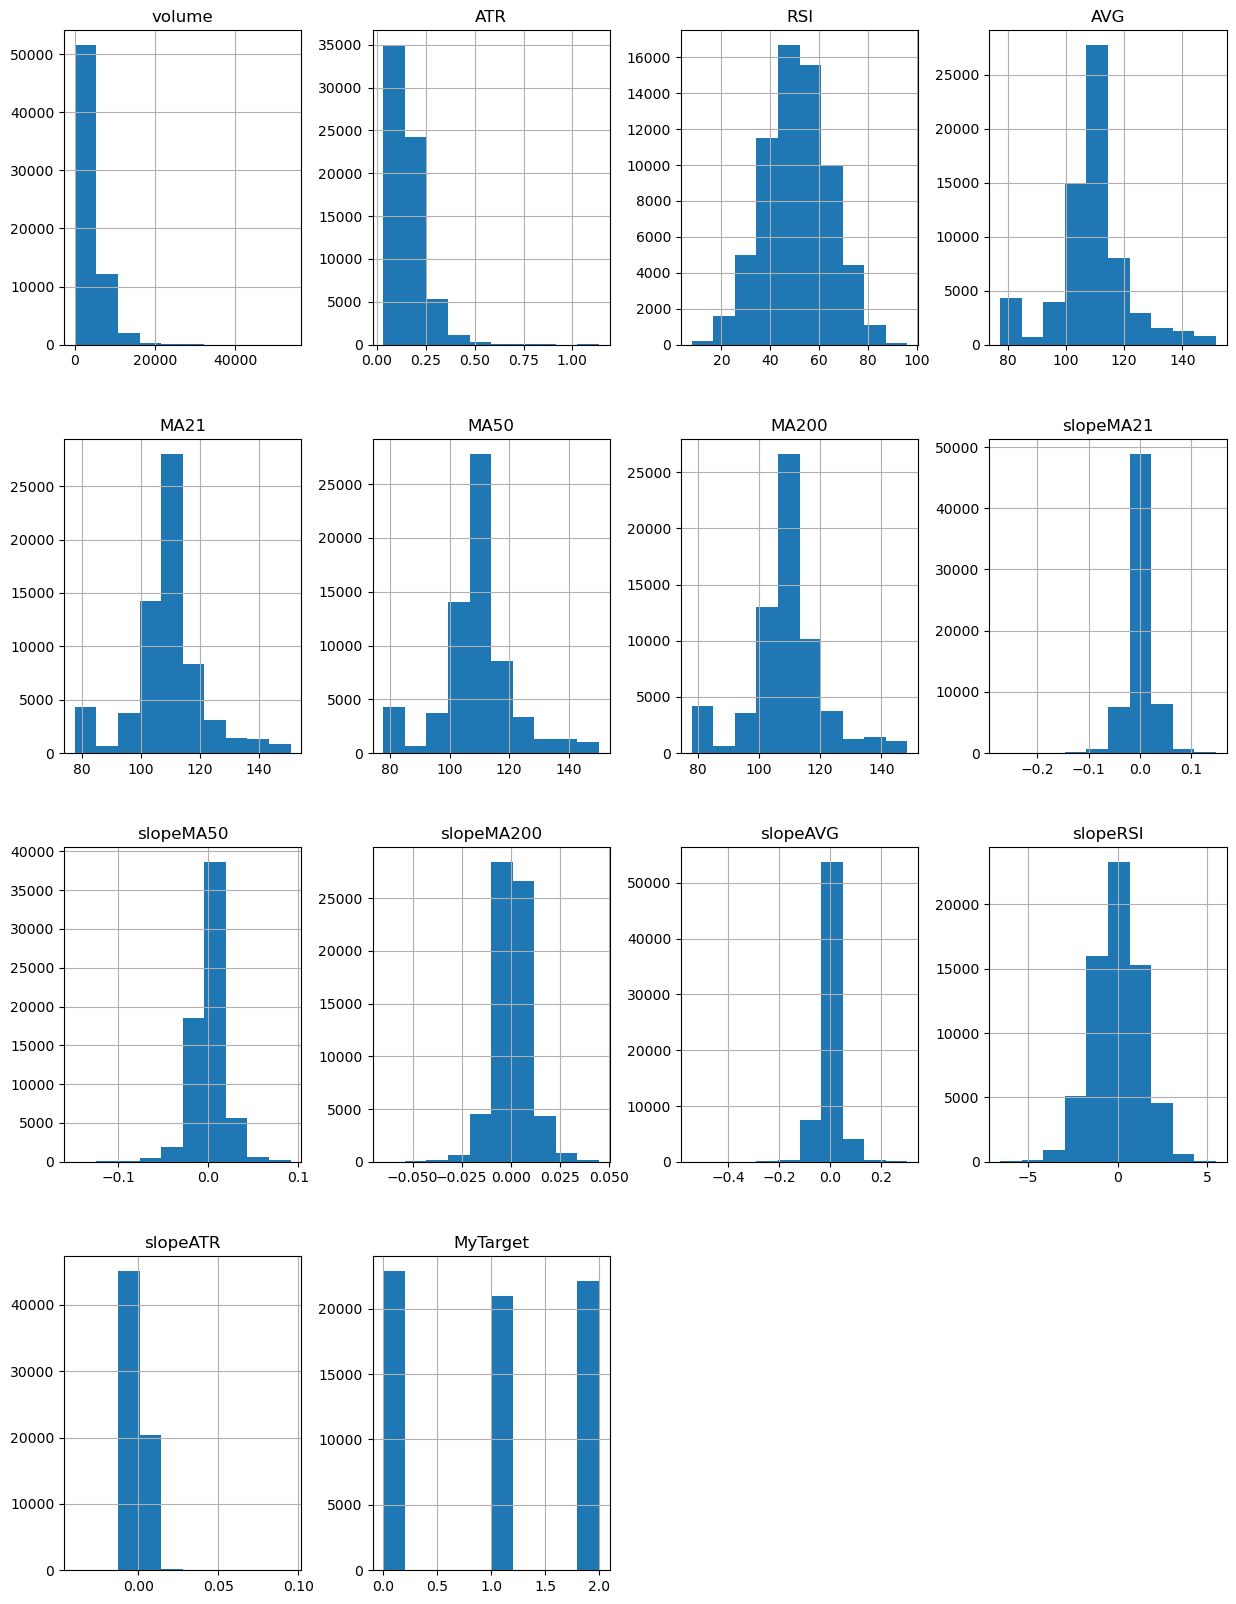

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['volume', 'ATR', 'RSI', 'AVG', 'MA21', 'MA50', 'MA200', 'slopeMA21', 'slopeMA50', 'slopeMA200', 'slopeAVG', 'slopeRSI', 'slopeATR', 'MyTarget']] 
df_model.hist(ax = ax)
plt.show()

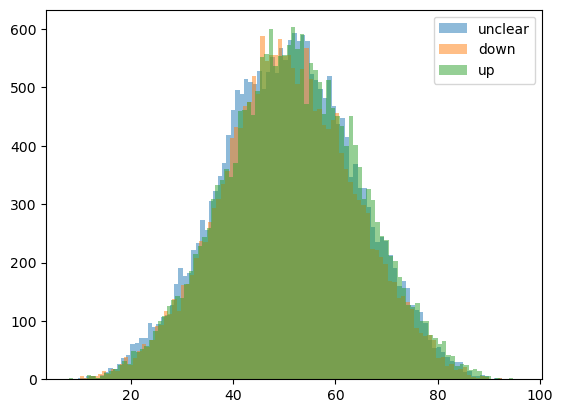

In [9]:
from matplotlib import pyplot
df_up=df.RSI[ df['MyTarget'] == 2 ]
df_down=df.RSI[ df['MyTarget'] == 1 ]
df_unclear=df.RSI[ df['MyTarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

Lets start testing multiple models, since we have categorical actions ( buy, sell, no trade ) we will use KNN first

In [10]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'AVG', 'MA21', 'MA50', 'MA200', 'slopeMA21', 'slopeMA50', 'slopeMA200', 'slopeAVG', 'slopeRSI', 'slopeATR']
X = df_model[attributes]
y = df_model["MyTarget"]

print(X)

            ATR        RSI       AVG        MA21        MA50       MA200  \
210    0.114634  39.592236   81.1440   81.238988   81.258467   81.162998   
211    0.127925  29.207524   80.9805   81.209625   81.245037   81.160541   
212    0.129930  27.445346   80.9530   81.178659   81.230291   81.157640   
213    0.128468  29.217167   80.8670   81.152145   81.216828   81.154947   
214    0.138437  23.881896   80.8070   81.114223   81.197933   81.150768   
...         ...        ...       ...         ...         ...         ...   
65967  0.366759  40.783768  137.1255  137.133379  136.757942  137.240857   
65968  0.364976  42.236329  136.8115  137.091617  136.754650  137.235216   
65969  0.372910  42.522716  136.6160  137.054743  136.751958  137.229751   
65970  0.366450  40.406702  136.6160  137.010584  136.744783  137.223177   
65971  0.364286  36.534929  136.5255  136.949531  136.728870  137.214379   

       slopeMA21  slopeMA50  slopeMA200  slopeAVG  slopeRSI  slopeATR  
210    -0.00788

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

C:\Users\Santiago\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Santiago\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `k

In [13]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

#------------------------------------------------------------------
#--- How should I compare my accuracy ?
print(df_model['MyTarget'].value_counts()*100/df_model['MyTarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 41.86%
Accuracy test: 40.14%
0.0    34.670478
2.0    33.539126
1.0    31.790396
Name: MyTarget, dtype: float64
Accuracy Gambler: 33.26%


In [14]:
#pip install xgboost

In [15]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 75.7684%
****Test Results****
Accuracy: 57.5686%


In [16]:
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 77.2073%
****Test Results****
Accuracy: 33.5361%


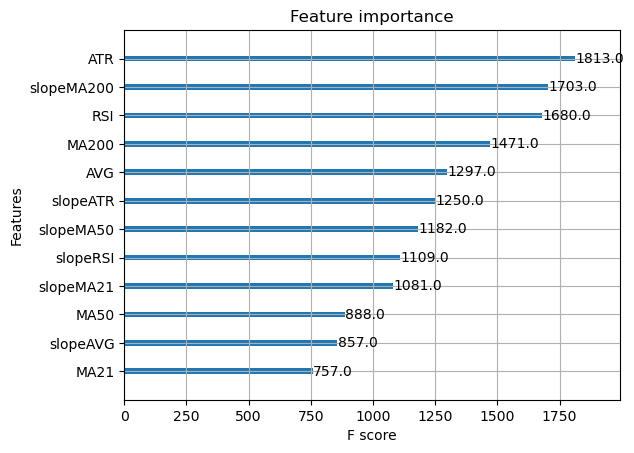

In [17]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()